In [1]:
import networkx as nx
import autograd.numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))
import lib.loss as loss
from lib.invite import graph_random_walk

In [4]:
# let's generate a graph G
# N = 30
# G = nx.watts_strogatz_graph(N, 4, .166)

sizes = [random.randint(1,6)+random.randint(1,6) # two d6 for population 
         for i in range(random.randint(1,6))]  # one d6 for number
print(sum(sizes), ': ', sizes)

p = 2.*np.identity(len(sizes)) + np.random.rand(len(sizes), len(sizes))
p = loss.softmax(p, axis=1)
p = (p.T+p)/2.

G = nx.stochastic_block_model(sizes, p)

19 :  [5, 4, 10]


C_β = 0.49


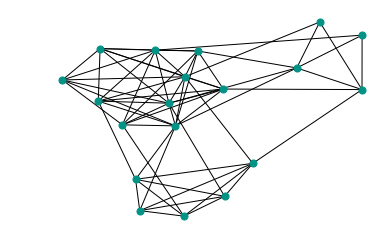

In [5]:
pos = nx.fruchterman_reingold_layout(G)
# pos = nx.circular_layout(G)
nx.draw_networkx(G, pos=pos, node_color='xkcd:teal', 
                 with_labels=False, node_size=50)
print(f'C_β = {nx.average_clustering(G):.2f}')

plt.axis('off');

In [6]:
m = [graph_random_walk(G).unique()[:5] for i in range(500)]

for n,i in enumerate(m[:4]):
    print(n, ' → '.join(f'[{j :^2.0f}]' for j in i.tolist()))
print('\n'.join(i for i in 3*['.']))
print(len(m)-1, ' → '.join(f'[{j :^2.0f}]' for j in m[-1].tolist()))

0 [9 ] → [13] → [11] → [10] → [14]
1 [11] → [8 ] → [7 ] → [5 ] → [9 ]
2 [13] → [9 ] → [10] → [12] → [2 ]
3 [12] → [5 ] → [8 ] → [7 ] → [0 ]
.
.
.
499 [2 ] → [1 ] → [4 ] → [3 ] → [0 ]


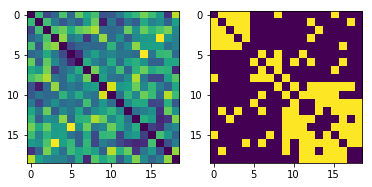

In [7]:
A = nx.to_numpy_array(G)

B = np.random.rand(*A.shape)
B = B.T + B - 2*np.diag(B.diagonal())

f,ax = plt.subplots(ncols=2)
ax[0].imshow(B)
ax[1].imshow(A)

/home/tbsexton/anaconda3/envs/eng-net/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


<IPython.core.display.Javascript object>


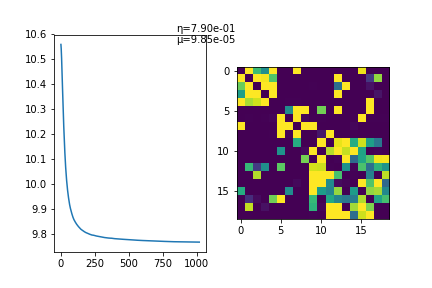

<IPython.core.display.Javascript object>


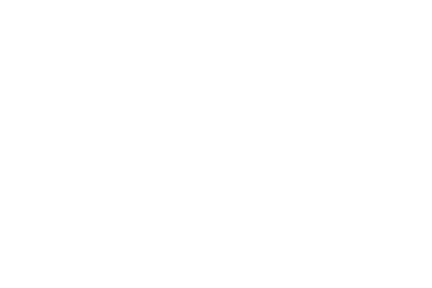

In [8]:
from lib.invite import graph_random_walk
import lib.loss as loss
from lib.opt import job_minibatch, job_per_round, Record

from autograd import grad
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib notebook

rec = Record(x_true=A)

A_approx = job_minibatch(loss.loss, B, m,
                         epochs=20,
                         learning_rate=0.9,
                         batch_size=10,
#                          reg=.01,
                         decay=True,
                         avg=True,
                         callback=rec.err_and_mat)



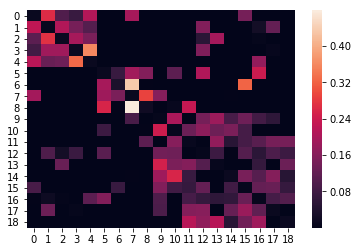

In [9]:
%matplotlib inline
import seaborn as sns
sns.heatmap(A_approx)

F_1 = 0.861


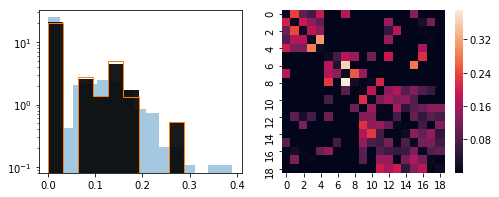

In [11]:
from sklearn import mixture, metrics

pre_thres = lambda a: np.log1p(a)
# pre_thres = lambda a: np.log(a+a.mean())

a =  pre_thres((A/A.sum(axis=1)).flatten())
a_ = pre_thres(A_approx.flatten())

gmm = mixture.BayesianGaussianMixture(n_components=2)
gmm.fit(a_.reshape(-1,1))
real_edge = gmm.predict(a_.reshape(-1,1))

if gmm.means_.argmin() == 1:  # flipped gmm classes
    print('flipping!')
    real_edge = np.where(real_edge==1, 0,1)

A_thres = real_edge.reshape(A.shape)
A_thres -= np.diag(A_thres.diagonal())

a_t = pre_thres((A_thres/A_thres.sum(axis=1)).flatten())


f_score = metrics.fbeta_score(real_edge, A.flatten(), 1.)
print(f'F_1 = {f_score:.3f}')

plt.figure(figsize=(8,3))
plt.subplot(121)    


sns.distplot(a_, norm_hist=True, kde=False)
sns.distplot(a, norm_hist=True, kde=False, color='k', hist_kws={"alpha": .9})
sns.distplot(a_t, 
             norm_hist=True, kde=False, hist_kws={"histtype": "step", 'alpha':1.})

plt.yscale('log')

plt.subplot(122)
sns.heatmap((pre_thres(A_approx)))

(0.8605577689243028, 0.8503937007874016, 0.8709677419354839)

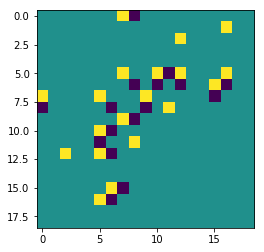

In [12]:
plt.imshow((A_thres - A))
res = (A_thres - A).flatten()
FP = (res>0).sum()
FN = (res<0).sum()
TP = A[A_thres>0].sum()

p = TP/(TP+FP)
r = TP/(TP+FN)
f = 2*p*r/(p+r)
f, p, r

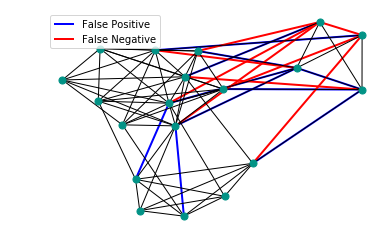

In [13]:
in_approx     = nx.from_numpy_array(A_thres - A > 0)
not_in_approx = nx.from_numpy_array(A - A_thres > 0)

nx.draw_networkx_edges(in_approx, pos=pos, 
                       edge_color='b', width=2., label='False Positive')
nx.draw_networkx_edges(not_in_approx, pos=pos, 
                       edge_color='r', width=2., label='False Negative')
nx.draw_networkx(G, pos=pos, node_color='xkcd:teal',
                with_labels=False, node_size=50)

plt.legend()
plt.axis('off');

### What about the easy way?

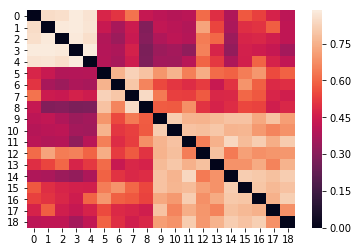

In [14]:
from sklearn import preprocessing as pre
from sklearn.metrics.pairwise import cosine_similarity

encode = pre.MultiLabelBinarizer(classes=range(A.shape[0]))
tags = encode.fit_transform(m)

cos = cosine_similarity(tags.T.dot(tags))
cos -= np.diag(cos.diagonal())
sns.heatmap(cos)

F_1 = 0.810


/home/tbsexton/anaconda3/envs/eng-net/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


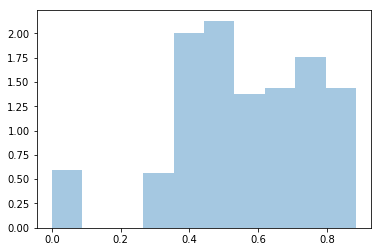

In [15]:
sns.distplot(cos.flatten(), norm_hist=True, kde=False)

gmm = mixture.BayesianGaussianMixture(n_components=2)
gmm.fit(cos.flatten().reshape(-1,1))

real_edge = gmm.predict(cos.flatten().reshape(-1,1))
if gmm.means_.argmin() == 1:  # flipped gmm classes
    print('flipping!')
    real_edge = np.where(real_edge==1, 0,1)
    
f_score = metrics.fbeta_score(real_edge, A.flatten(), 1.)
print(f'F_1 = {f_score:.3f}')

cos_thres = real_edge.reshape(A.shape)
cos_thres -= np.diag(A_thres.diagonal())

# thres = .7
# cos_thres = (cos.flatten()>thres).reshape(A.shape)
# print(metrics.fbeta_score(cos.flatten()>thres, A.flatten(), 1.))


(0.8307692307692308, 0.8852459016393442, 0.782608695652174)

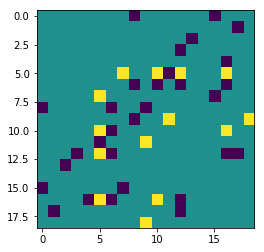

In [16]:
plt.imshow((cos_thres - A))
res = (cos_thres - A).flatten()
FP = (res>0).sum()
FN = (res<0).sum()
TP = A[A_thres>0].sum()

p = TP/(TP+FP)
r = TP/(TP+FN)
f = 2*p*r/(p+r)
f, p, r

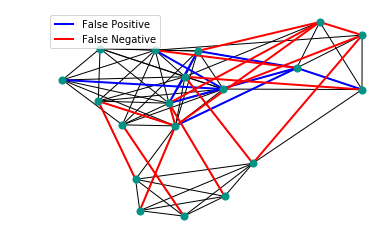

In [17]:
in_cos     = nx.from_numpy_array(cos_thres - A > 0)
not_in_cos = nx.from_numpy_array(A - cos_thres > 0)

nx.draw_networkx(G, pos=pos, node_color='xkcd:teal',
                with_labels=False, node_size=50)
nx.draw_networkx_edges(in_cos, pos=pos, 
                       edge_color='b', width=2., label='False Positive')
nx.draw_networkx_edges(not_in_cos, pos=pos, 
                       edge_color='r', width=2., label='False Negative')
plt.legend()
plt.axis('off');